In [1]:
from pathlib import Path
import pickle
import numpy as np

from crater import Tensor, Gradients
from crater.operations import matrix_multiply
from crater.utils import one_hot

from IPython.display import display
from PIL import Image
import plotly.graph_objects as go
from tqdm.auto import tqdm, trange

In [2]:
def load_batch(filename: str):
    with (Path("../data") / filename).open("rb") as file:
        result = pickle.load(file, encoding="bytes")
    return dict(data=result[b"data"], labels=result[b"labels"])

train_data = load_batch("data_batch_1")
validation_data = load_batch("data_batch_2")
test_data = load_batch("test_batch")

train_data["data"]

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

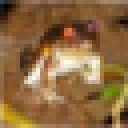

In [3]:
def vector_to_image(vector: np.ndarray):
    return (
        Image
        .fromarray(np.moveaxis(np.reshape(vector, [3, 32, 32]), source=0, destination=-1))
        .resize([128, 128], resample=Image.NEAREST)
    )

vector_to_image(train_data["data"][0])

In [4]:
data_mean = np.mean(train_data["data"])
data_std = np.std(train_data["data"])

def normalize_data(data: np.ndarray):
    return Tensor.from_numpy((data - data_mean) / data_std)

normalize_data(train_data["data"][:2])

Tensor(data=array([[-0.96351073, -1.2119942 , -1.10328268, ...,  0.29443685,
        -0.5752553 , -0.76161791],
       [ 0.51185989,  0.07701381, -0.24912075, ...,  0.27890663,
         0.32549728,  0.35655772]]), backward=None)

In [5]:
class Classifier:
    def __init__(self):
        self.weights = Tensor.from_numpy(np.random.normal(scale=.01, size=[32 * 32 * 3, 10]))
        self.biases = Tensor.from_numpy(np.random.normal(scale=.01, size=[10]))
    
    def logits(self, data):
        return matrix_multiply(normalize_data(data), self.weights) + self.biases
    
    def probabilities(self, data):
        return self.logits(data).softmax(-1)
    
    def loss(self, batch, regularization):
        cross_entropy = -(
            (self.probabilities(batch["data"]).log() * one_hot(batch["labels"], num_classes=10)).sum()
            / Tensor.from_builtin(len(batch["data"]))
        )
        penalty = (self.weights * self.weights).sum() * Tensor.from_builtin(regularization)
        return cross_entropy + penalty
    
    def gradients(self, batch, regularization):
        return Gradients.trace(self.loss(batch, regularization))
    
    def predictions(self, data):
        return np.argmax(self.logits(data).data, axis=-1)
    
    def accuracy(self, batch):
        return np.mean(self.predictions(batch["data"]) == batch["labels"])
    
    def train_step(self, batch, regularization, learning_rate):
        gradients = self.gradients (batch, regularization)
        self.weights = Tensor.from_numpy(self.weights.data - gradients[self.weights] * learning_rate)
        self.biases = Tensor.from_numpy(self.biases.data - gradients[self.biases] * learning_rate)

classifier = Classifier()
classifier.loss(train_data, regularization=0.01)

Tensor(data=2.4429146941102995, backward=<function add.<locals>.<lambda> at 0x7f527b46a3a0>)

In [6]:
example_gradients = classifier.gradients(train_data, regularization=0.01)
example_gradient_values = [
    value
    for gradient in [example_gradients[classifier.weights], example_gradients[classifier.biases]]
    for value in gradient.flatten()
]

go.Figure(
    layout=dict(
        title="Distribution of gradient values",
        xaxis_title="Gradient",
        yaxis_title="Number of values",
    ),
    data=go.Histogram(
        x=example_gradient_values
    ),
)

In [7]:
classifier.predictions(train_data["data"][:10])

array([9, 6, 8, 6, 6, 0, 6, 6, 2, 6])

In [8]:
classifier.accuracy(train_data)

0.1081

In [9]:
def train_epoch(classifier, num_per_batch=100, learning_rate=1e-3, regularization=1e-3):
    for start_idx in range(0, len(train_data["data"]), num_per_batch):
        batch = {
            name: array[start_idx : start_idx + num_per_batch]
            for name, array in train_data.items()
        }
        classifier.train_step(batch, regularization=regularization, learning_rate=learning_rate)

        
train_epoch(classifier)

In [10]:
classifier.accuracy(train_data)

0.289

In [11]:
def train(classifier, num_epochs=40, num_per_batch=100, learning_rate=1e-3, regularization=1e-3):
    train_losses = []
    validation_losses = []
    
    for epoch in trange(num_epochs):
        train_epoch(classifier)
        train_losses.append(classifier.loss(train_data, regularization=regularization).data)
        validation_losses.append(classifier.loss(validation_data, regularization=regularization).data)
    
    return train_losses, validation_losses

classifier = Classifier()
train(classifier, num_epochs=4)

  0%|          | 0/4 [00:00<?, ?it/s]

([1.9695996481080909,
  1.891558498477188,
  1.8504491832929744,
  1.823260497958771],
 [2.0012136328267722,
  1.9355409741350194,
  1.9040275170988519,
  1.8848088272252497])

  0%|          | 0/4 [00:00<?, ?it/s]

Test accuracy: 0.3523


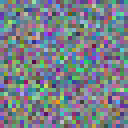

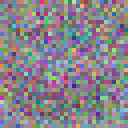

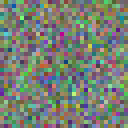

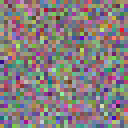

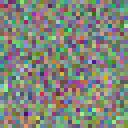

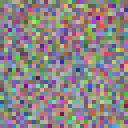

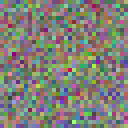

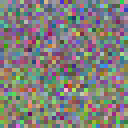

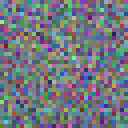

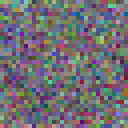

In [12]:
def experiment(num_epochs=40, num_per_batch=100, learning_rate=1e-3, regularization=1e-3):
    classifier = Classifier()
    train_losses, validation_losses = train(
        classifier=classifier,
        num_epochs=num_epochs,
        num_per_batch=num_per_batch,
        learning_rate=learning_rate,
        regularization=regularization,
    )
    
    print(f"Test accuracy: {classifier.accuracy(test_data)}")
    figure = go.Figure(
        layout=dict(
            title="Training progress",
            xaxis_title="Epoch number",
            yaxis_title="Loss",
        ),
        data=[
            go.Scatter(
                name="Train",
                y=train_losses,
            ),
            go.Scatter(
                name="Validation",
                y=validation_losses,
            ),
        ]
    )
    display(figure)
    
    for template in classifier.weights.data.T:
        normalized = (template - template.min()) / (template.max() - template.min())
        display(vector_to_image((normalized * 255).astype(np.uint8)))
    
experiment(num_epochs=4)

  0%|          | 0/40 [00:00<?, ?it/s]

Test accuracy: 0.3875


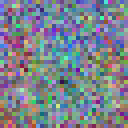

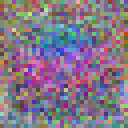

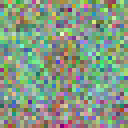

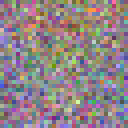

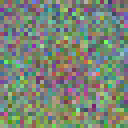

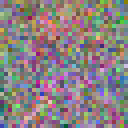

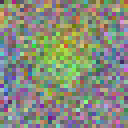

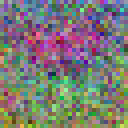

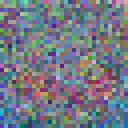

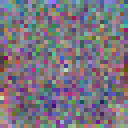

In [13]:
experiment(regularization=0, num_epochs=40, num_per_batch=100, learning_rate=.1)

  0%|          | 0/40 [00:00<?, ?it/s]

Test accuracy: 0.3878


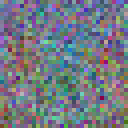

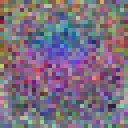

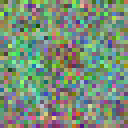

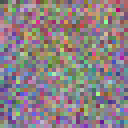

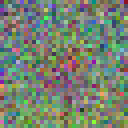

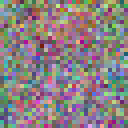

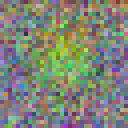

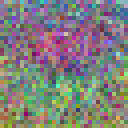

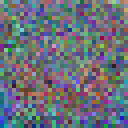

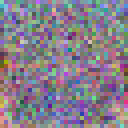

In [14]:
experiment(regularization=0, num_epochs=40, num_per_batch=100, learning_rate=.001)

  0%|          | 0/40 [00:00<?, ?it/s]

Test accuracy: 0.3847


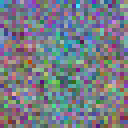

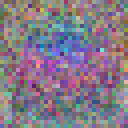

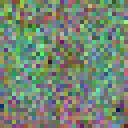

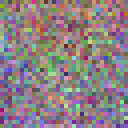

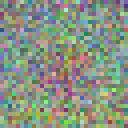

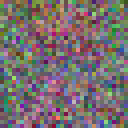

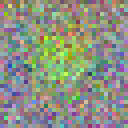

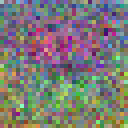

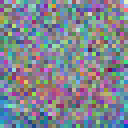

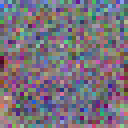

In [15]:
experiment(regularization=.1, num_epochs=40, num_per_batch=100, learning_rate=.001)

  0%|          | 0/40 [00:00<?, ?it/s]

Test accuracy: 0.3852


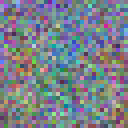

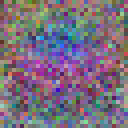

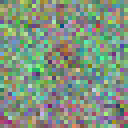

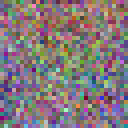

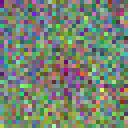

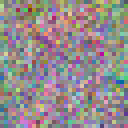

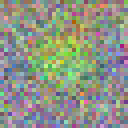

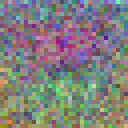

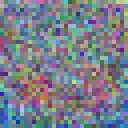

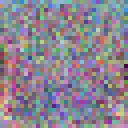

In [16]:
experiment(regularization=1, num_epochs=40, num_per_batch=100, learning_rate=.001)